# 1. Data Parsing

In [1]:
import numpy as np
import pandas as pd
import numpy.linalg as la
import scipy.stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

In [3]:
data = pd.read_csv('airline_data.csv')

In [4]:
data

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,...,4,2,2,0,2,4,2,5,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,satisfied,Female,disloyal Customer,29,Personal Travel,Eco,1731,5,5,5,...,2,2,3,3,4,4,4,2,0,0.0
129876,dissatisfied,Male,disloyal Customer,63,Personal Travel,Business,2087,2,3,2,...,1,3,2,3,3,1,2,1,174,172.0
129877,dissatisfied,Male,disloyal Customer,69,Personal Travel,Eco,2320,3,0,3,...,2,4,4,3,4,2,3,2,155,163.0
129878,dissatisfied,Male,disloyal Customer,66,Personal Travel,Eco,2450,3,2,3,...,2,3,3,2,3,2,1,2,193,205.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       129880 non-null  object 
 1   Gender                             129880 non-null  object 
 2   Customer Type                      129880 non-null  object 
 3   Age                                129880 non-null  int64  
 4   Type of Travel                     129880 non-null  object 
 5   Class                              129880 non-null  object 
 6   Flight Distance                    129880 non-null  int64  
 7   Seat comfort                       129880 non-null  int64  
 8   Departure/Arrival time convenient  129880 non-null  int64  
 9   Food and drink                     129880 non-null  int64  
 10  Gate location                      129880 non-null  int64  
 11  Inflight wifi service              1298

# 2. Data Preprocessing

In [6]:
def preprocess(df):
    df = df.copy() #we want to create a copy of the dataframe
    df['Arrival Delay in Minutes'] =df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].mean())
    
    #To distinguish binary variables, we are going to use binary classification
    df['Gender'] = df['Gender'].replace({'Female': 0, 'Male': 1})
    df['Customer Type'] = df['Customer Type'].replace({'disloyal Customer': 0, 'Loyal Customer': 1})
    df['Type of Travel'] = df['Type of Travel'].replace({'Personal Travel': 0, 'Business travel': 1})
    ##################################################################
    
    #One hot coding
    flight_class = pd.get_dummies(df['Class'],prefix='Flight')
    df = pd.concat([df,flight_class],axis=1)
    df = df.drop('Class',axis=1)
    return df


In [7]:
def classify_objects(X):
    return {col: len(X[col].unique()) for col in X.select_dtypes('object').columns} ,{col: list(X[col].unique()) for col in X.select_dtypes('object').columns}

In [8]:
class_len, class_list = classify_objects(data) #after preprocessing all the data, we are going to classify them into data classes
print('class_len:',class_len)
print('class_list:',class_list)

class_len: {'satisfaction': 2, 'Gender': 2, 'Customer Type': 2, 'Type of Travel': 2, 'Class': 3}
class_list: {'satisfaction': ['satisfied', 'dissatisfied'], 'Gender': ['Female', 'Male'], 'Customer Type': ['Loyal Customer', 'disloyal Customer'], 'Type of Travel': ['Personal Travel', 'Business travel'], 'Class': ['Eco', 'Business', 'Eco Plus']}


In [9]:
X = preprocess(data)
X

,satisfaction,Gender,Customer Type,Age,Type of Travel,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,Flight_Business,Flight_Eco,Flight_Eco Plus
0,satisfied,0,1,65,0,265,0,0,0,2,...,0,3,5,3,2,0,0.0,0,1,0
1,satisfied,1,1,47,0,2464,0,0,0,3,...,4,4,2,3,2,310,305.0,1,0,0
2,satisfied,0,1,15,0,2138,0,0,0,3,...,3,4,4,4,2,0,0.0,0,1,0
3,satisfied,0,1,60,0,623,0,0,0,3,...,0,1,4,1,3,0,0.0,0,1,0
4,satisfied,0,1,70,0,354,0,0,0,3,...,0,2,4,2,5,0,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,satisfied,0,0,29,0,1731,5,5,5,3,...,3,4,4,4,2,0,0.0,0,1,0
129876,dissatisfied,1,0,63,0,2087,2,3,2,4,...,3,3,1,2,1,174,172.0,1,0,0
129877,dissatisfied,1,0,69,0,2320,3,0,3,3,...,3,4,2,3,2,155,163.0,0,1,0
129878,dissatisfied,1,0,66,0,2450,3,2,3,2,...,2,3,2,1,2,193,205.0,0,1,0


# 3. Outliers Checking

In [15]:
drop_sat_df = X.drop('satisfaction', axis=1).copy()
#check if there are more than two types of classification data variables
non_binary_columns = [col for col in drop_sat_df.columns if len(drop_sat_df[col].unique()) > 2]
print(len(non_binary_columns))

18


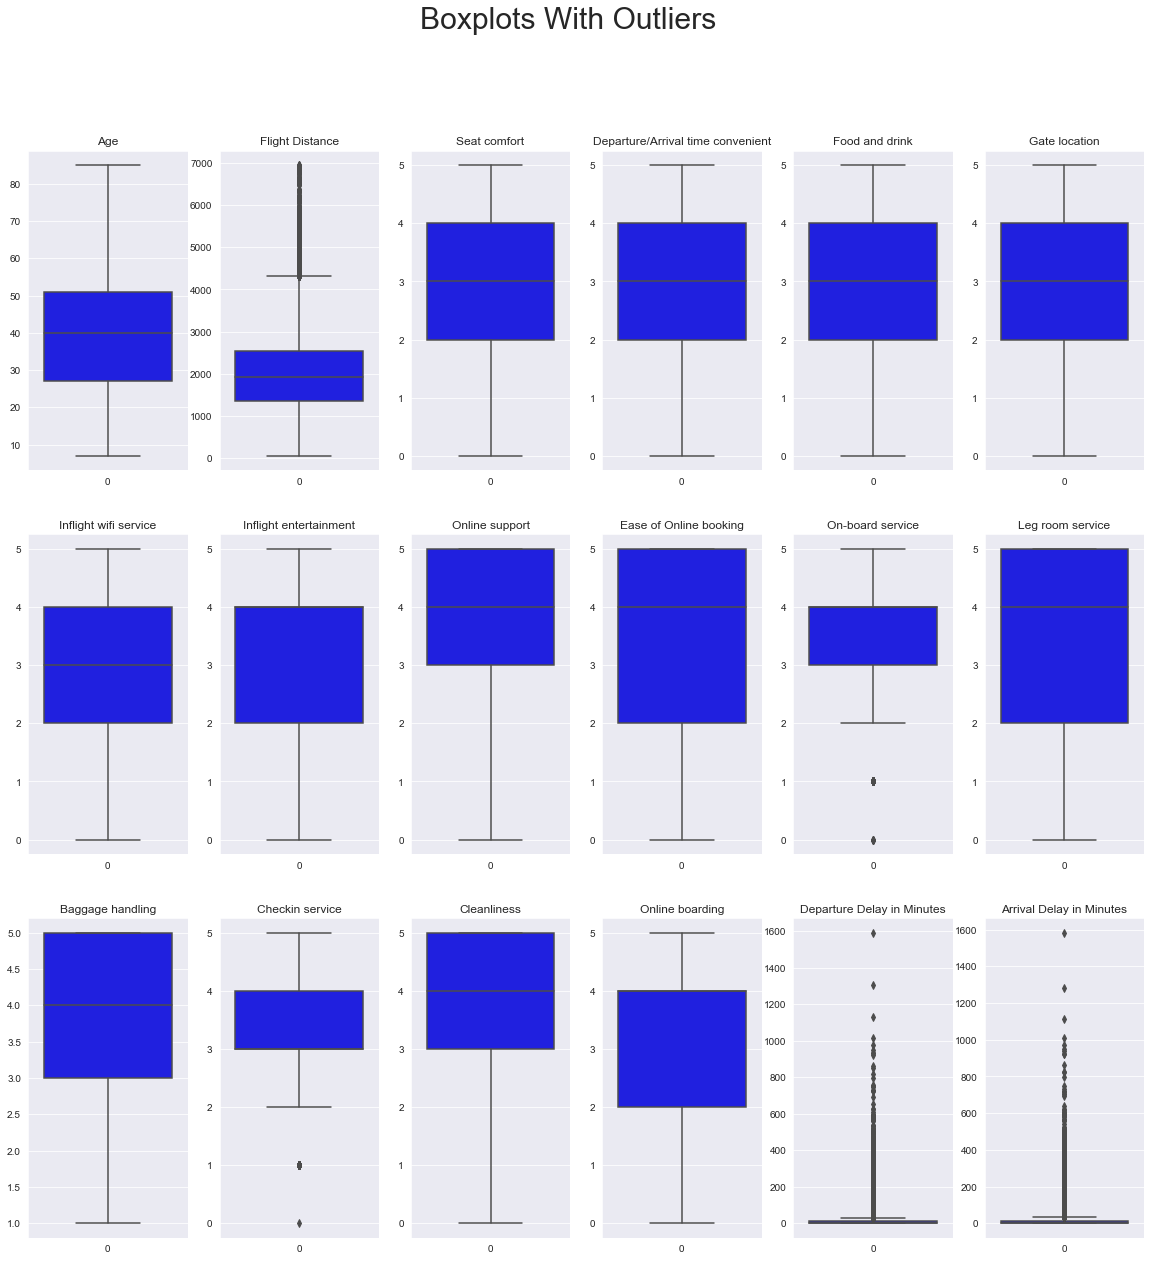

In [22]:
plt.figure(figsize=(20,20))
for idx, col in enumerate(non_binary_columns):
    plt.subplot(3,6,idx + 1)
    sns.boxplot(data=drop_sat_df[col],color='blue')
    plt.title(col)

plt.suptitle('Boxplots With Outliers',size=30)
plt.show()